In [1]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18
import nibabel as nib
import numpy as np
from skimage.color import gray2rgb
import pandas as pd
import random
from scipy.ndimage import gaussian_filter

In [2]:
class SEBlock(nn.Module):
    def __init__(self, input_dim, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim // reduction, input_dim, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        self.saved_attention = y
        return x * y.expand_as(x)

class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.se_block = SEBlock(planes * self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Apply SE block
        out = self.se_block(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    def get_attention_weight(self):
        return self.se_block.saved_attention

# Load the pre-built 3D ResNet model
model = r3d_18(pretrained=True, progress=True)

# Replace the first convolution layer for single-channel input
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

# Replace existing blocks with SEBasicBlock
def make_layer(block, inplanes, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            nn.Conv3d(inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm3d(planes * block.expansion),
        )

    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))

    return nn.Sequential(*layers)

# if you want 18 layers, use the following
# model.layer1 = make_layer(SEBasicBlock, 64, 64, 2)
# model.layer2 = make_layer(SEBasicBlock, 64, 128, 2, stride=2)
# model.layer3 = make_layer(SEBasicBlock, 128, 256, 2, stride=2)
# model.layer4 = make_layer(SEBasicBlock, 256, 512, 2, stride=2)

# if you want 9 layers, use the following
model.layer1 = make_layer(SEBasicBlock, 64, 64, 1) 
model.layer2 = make_layer(SEBasicBlock, 64, 128, 1, stride=2)  
model.layer3 = make_layer(SEBasicBlock, 128, 256, 1, stride=2) 
model.layer4 = make_layer(SEBasicBlock, 256, 512, 1, stride=2)  

# Replace the fully connected layer for specific output size
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=3)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)


C:\Users\duson\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\duson\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


In [3]:
weights_path = r'D:\Juntao\Code\old results 9 layers-1128\model_weights_epoch_9.pth'
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [4]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()
image_data_torch=torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)
with torch.no_grad():
    output = model(image_data_torch)
    print(output)

tensor([[ 1.2753, -0.2579, -1.9518]], device='cuda:0')


In [5]:
import numpy as np
import torch
from sklearn.linear_model import LinearRegression

def predict(model, data):
    """
    使用模型进行预测的函数。
    """
    data_torch=torch.tensor(data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(data_torch).detach().to('cpu').numpy()

def apply_3d_gaussian_blur_on_region(data, mask, region, sigma=1):
    """
    对三维数据的指定区域应用高斯模糊。
    :param data: 完整的三维 numpy 数组。
    :param mask: 定义区域的掩码。
    :param region: 要模糊的区域的标记。
    :param sigma: 高斯核的标准差。
    :return: 高斯模糊后的完整数据。
    """
    # 创建一个与原始数据形状相同的数组用于存放结果
    result = np.copy(data)

    # 提取感兴趣的区域
    region_data = data[mask == region]

    # 对这个区域应用高斯模糊
    blurred_region = gaussian_filter(region_data, sigma=sigma)

    # 将模糊后的数据放回原始数据集
    result[mask == region] = blurred_region

    return result

def generate_perturbations(data, mask,model,num_samples=50,method='shaded'):
    """
    生成扰动样本。
    """
    num_regions = int(np.max(mask))  # 假设区域编号从1到最大值
    unique_values = np.unique(mask)
    non_zero_regions = [int(value) for value in unique_values if np.count_nonzero(mask == value) > 0]
    print('non zero regions:', len(non_zero_regions))
    Y = []
    X = []

    for i in range(num_samples):
        # 随机选择一半区域进行扰动
        region_to_perturb = random.sample(non_zero_regions, int(len(non_zero_regions)/2))
        result_array = np.ones(num_regions+1, dtype=int)
        for index in region_to_perturb:
            if 0 <= index < len(result_array):
                result_array[index] = 0
        X.append(result_array)

        # 生成扰动
        perturbed_sample = np.copy(data)
        if method=='noise':      # adding noise
            perturbation = np.random.normal(0, 0.1, data.shape)
            for region in region_to_perturb:
                perturbed_sample[mask == region] += np.random.normal(0,0.1,perturbed_sample[mask == region].shape)
        elif method=='occlusion': # remove the certain area
            for region in region_to_perturb:
                perturbed_sample[mask == region] =0
        elif method=='blurring': # Apply 3d gaussian flur
            for region in region_to_perturb:
                apply_3d_gaussian_blur_on_region(perturbed_sample,mask,region)
        elif method== 'inversion':
            for region in region_to_perturb:
                perturbed_sample[mask == region] = 255 - perturbed_sample[mask == region]
                
        Y.append(predict(model,perturbed_sample)[0])

        if i % 10 == 0:
            print(i)
    
    return X, Y

def calculate_inverse_ratios(image):
    image_int = image.astype(int)
    pixel_counts = np.bincount(image_int.ravel(), minlength=78)
    total_pixels = image_int.size
    ratios = pixel_counts / total_pixels
    ratios[ratios == 0] = np.inf
    inverse_ratios = 1 / ratios

    return inverse_ratios.tolist()
    

In [106]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()
v_vector=calculate_inverse_ratios(mask_data)

#for method in ['noise','occlusion','blurring','inversion']:
for method in ['blurring','inversion']:
    X, Y = generate_perturbations(input_data,mask_data,model, 50,method)
    Y=np.array(Y)
    
    regressor0 = LinearRegression()
    regressor1 = LinearRegression()
    regressor2 = LinearRegression()
    regressor0.fit(np.array(X)*v_vector, Y[:,0])
    regressor1.fit(np.array(X)*v_vector, Y[:,1])
    regressor2.fit(np.array(X)*v_vector, Y[:,2])

    pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_%s.csv'%method)

# print(regressor0.coef_)
# print(regressor1.coef_)
# print(regressor2.coef_)

# pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_%s.csv'%method)

non zero regions: 36
0
10
20
30
40
non zero regions: 36
0
10
20
30
40


In [107]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\082_S_6690.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\082_S_6690.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()
v_vector=calculate_inverse_ratios(mask_data)

for method in ['noise','occlusion','blurring','inversion']:
# for method in ['blurring','inversion']:
    X, Y = generate_perturbations(input_data,mask_data,model, 50,method)
    Y=np.array(Y)
    
    regressor0 = LinearRegression()
    regressor1 = LinearRegression()
    regressor2 = LinearRegression()
    regressor0.fit(np.array(X)*v_vector, Y[:,0])
    regressor1.fit(np.array(X)*v_vector, Y[:,1])
    regressor2.fit(np.array(X)*v_vector, Y[:,2])

    pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\082_S_6690_%s.csv'%method)

# print(regressor0.coef_)
# print(regressor1.coef_)
# print(regressor2.coef_)

# pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_%s.csv'%method)

non zero regions: 36
0
10
20
30
40
non zero regions: 36
0
10
20
30
40
non zero regions: 36
0
10
20
30
40
non zero regions: 36
0
10
20
30
40


In [ ]:
import statsmodels.api as sm
import numpy as np

# X = np.array(X)*v_vector  
# y = Y[:,2]    

# X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

summary_str = model.summary().as_text()

# 使用 Matplotlib 创建图像
fig, ax = plt.subplots(figsize=(10, 20))
# 隐藏实际的坐标轴
ax.axis('off')
# 将摘要作为文本添加到图像上
plt.text(0.01, 0.05, summary_str, {'fontsize': 10}, fontname='monospace')

# 保存图像
plt.savefig(r'D:\Juntao\Data\ANDI3-T1\results\summary.png', dpi=500)

In [ ]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\082_S_6690.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\082_S_6690.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()
v_vector=calculate_inverse_ratios(mask_data)

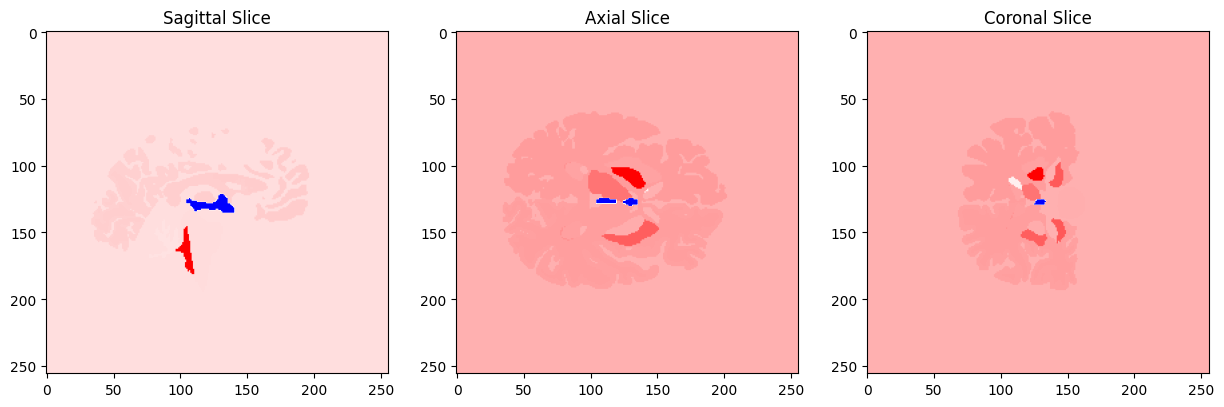

In [99]:
import matplotlib.pyplot as plt

def normalize_11(array,mask):
    unique_values = np.unique(mask)
    non_zero_regions = [int(value) for value in unique_values if np.count_nonzero(mask == value) > 0]
    binary_array = np.zeros(78)
    binary_array[np.array(non_zero_regions) - 1] = 1
    return (2 * (array - array.min()) / (array.max() - array.min()) - 1)*binary_array

def get_interpretation(mri_image,mask,array):
    normalized_array = normalize_11(array,mask)
    for i in range(len(normalized_array)):
        mri_image[mask == i] = normalized_array[i]
    
    return mri_image

mri_image=get_interpretation(input_data,mask_data,regressor2.coef_)

slice1 = mri_image[mri_image.shape[0] // 2, :, :]
slice2 = mri_image[:, mri_image.shape[1] // 2, :]
slice3 = mri_image[:, :, mri_image.shape[2] // 2]

cmap = plt.cm.bwr

# Plot the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(slice1, cmap=cmap)
axes[0].set_title('Sagittal Slice')
axes[1].imshow(slice2, cmap=cmap)
axes[1].set_title('Axial Slice')
axes[2].imshow(slice3, cmap=cmap)
axes[2].set_title('Coronal Slice')
plt.show()
fig.savefig(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_noise.png', dpi=300) 

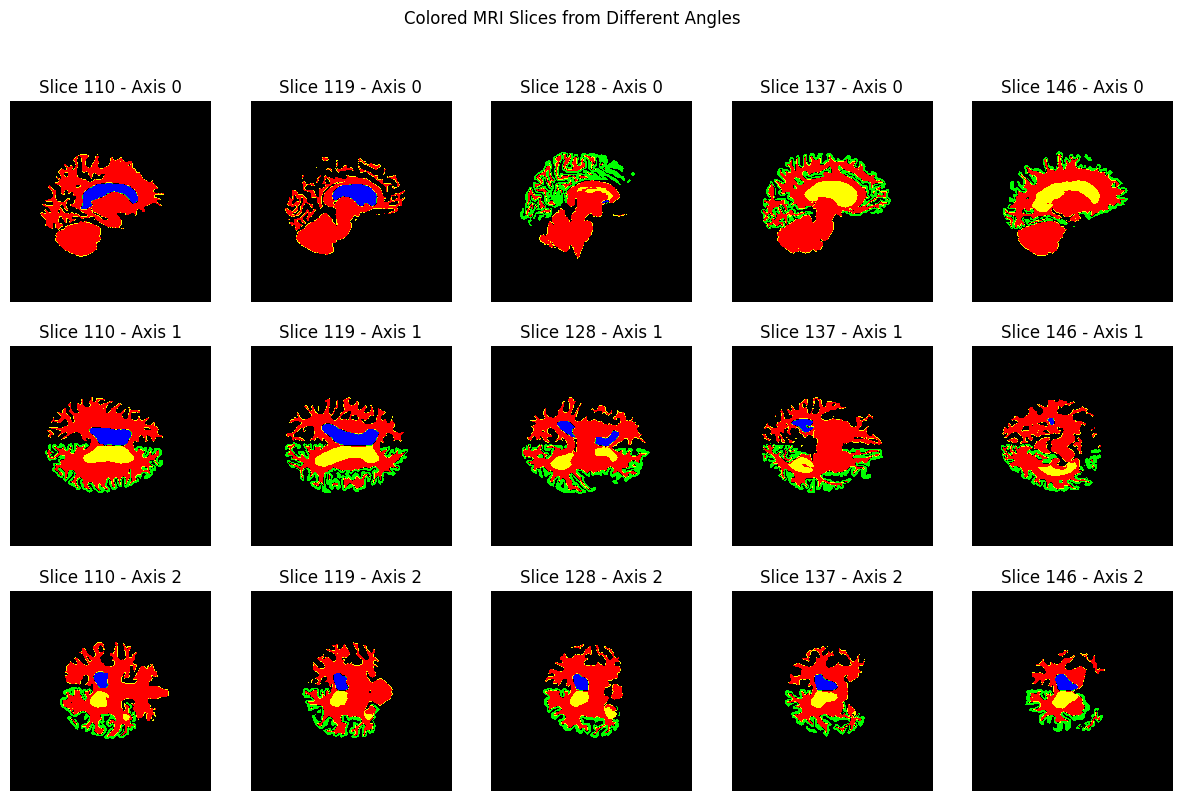

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

mri_image=input_data
mask=mask_data
importance=normalize_11(regressor2.coef_,mask)

# 创建颜色映射
colors = [(0, 0, 1), (0, 1, 0),(0, 0, 0), (1, 1, 0), (1, 0, 0)]  # B, G,black, Y, R
cm = mcolors.LinearSegmentedColormap.from_list('importance_map', colors, N=5)

# 找出绝对值大于0.2的索引
important_indices = np.where(np.abs(importance) > 0.1)[0] + 1

# 创建一个新的图像用于显示
colored_image = np.zeros_like(mri_image, dtype=float)

# 根据mask和重要性为新图像上色
for idx in important_indices:
    mask_idx = mask == idx
    colored_image[mask_idx] = importance[idx - 1]

# 融合原始图像和新图像


# 选择切片位置（靠近中间部分的切片）
slice_positions = np.round(np.linspace(110, 146, 5)).astype(int)  # 靠近中间部分的切片位置

# 画图
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, slice_pos in enumerate(slice_positions):
    # 沿不同方向的切片
    axes[0, i].imshow(colored_image[slice_pos, :, :], cmap=cm, vmin=-1, vmax=1)
    axes[0, i].set_title(f"Slice {slice_pos} - Axis 0")
    axes[0, i].axis('off')

    axes[1, i].imshow(colored_image[:, slice_pos, :], cmap=cm, vmin=-1, vmax=1)
    axes[1, i].set_title(f"Slice {slice_pos} - Axis 1")
    axes[1, i].axis('off')

    axes[2, i].imshow(colored_image[:, :, slice_pos], cmap=cm, vmin=-1, vmax=1)
    axes[2, i].set_title(f"Slice {slice_pos} - Axis 2")
    axes[2, i].axis('off')

fig.suptitle("Colored MRI Slices from Different Angles")
plt.show()

fig.savefig(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_inversion_AD.png', dpi=500) 



In [76]:
colored_image[mask == 70]

array([], dtype=float64)

(array([2.41875e+05, 2.30030e+05, 6.74300e+03, 0.00000e+00, 1.75000e+02,
        0.00000e+00, 1.37350e+04, 0.00000e+00, 4.82510e+04, 0.00000e+00,
        8.00700e+03, 0.00000e+00, 3.40700e+03, 4.59100e+03, 1.97100e+03,
        0.00000e+00, 9.45000e+02, 1.38100e+03, 2.00590e+04, 0.00000e+00,
        4.30900e+03, 1.49600e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.10900e+03,
        0.00000e+00, 0.00000e+00, 5.14000e+02, 0.00000e+00, 4.05700e+03,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 6.73000e+02, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 2.41542e+05, 2.31072e+05, 7.83600e+03,
        0.00000e+00, 1.47000e+02, 0.00000e+00, 1.35420e+04, 0.00000e+00,
        4.87490e+04, 0.00000e+00, 7.81100e+03, 0.00000e+00, 3.56300e+03,
        4.54600e+03, 1.81800e+03, 0.00000e+00, 4.27

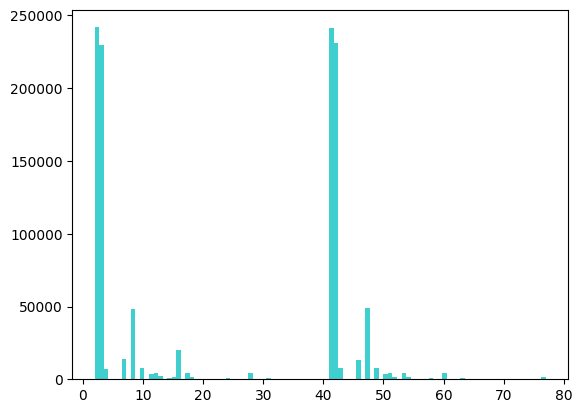

In [84]:
plt.hist(mask[mask>0].ravel(), bins=100, color='c', alpha=0.75)

([<matplotlib.axis.XTick at 0x1f958900550>,
 [Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '')])

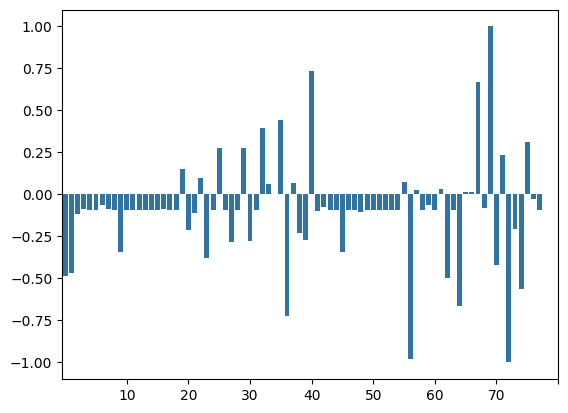

In [85]:
import seaborn as sns
sns.barplot(normalize_11(regressor0.coef_))
plt.xticks(np.arange(10, 81, 10))

([<matplotlib.axis.XTick at 0x1f598e24e20>,
 [Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '')])

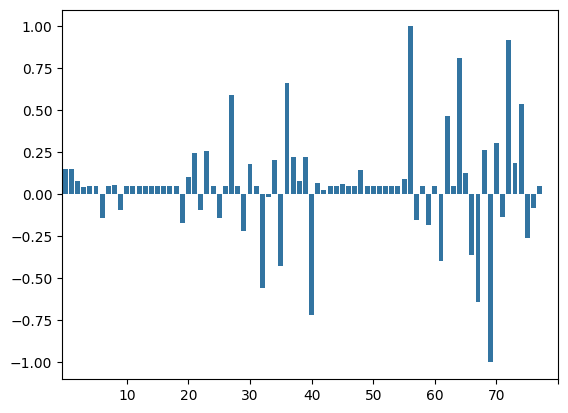

In [86]:
sns.barplot(normalize_11(regressor2.coef_))
plt.xticks(np.arange(10, 81, 10))

### Trasfer weight vector to a DataFrame with the region mapping.

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
mapping=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\brain_structures.csv')
df_inversion=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_inversion.csv').iloc[2:3,1:].T
df_inversion=-df_inversion
# df_blurring=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_blurring.csv').iloc[2:3,1:].T
df_noise=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_noise.csv').iloc[2:3,1:].T
df_occlusion=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_occlusion.csv').iloc[2:3,1:].T
df_att1=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT1.csv').iloc[:,2:3]
df_att2=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT2.csv').iloc[:,2:3]
df_att3=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT3.csv').iloc[:,2:3]
df_att4=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT4.csv').iloc[:,2:3]

df=pd.concat([mapping,df_inversion.reset_index(drop=True)
                  # ,df_blurring.reset_index(drop=True)
                  ,df_noise.reset_index(drop=True)
                  ,df_occlusion.reset_index(drop=True)
                 ,df_att1.reset_index(drop=True)
                 ,df_att2.reset_index(drop=True)
                 ,df_att3.reset_index(drop=True)
                 ,df_att4.reset_index(drop=True)
                 ],axis=1,ignore_index=True)

df.columns=['Region','Fastsurfer','Freefurfer','Group','inversion','noise','occlusion','attention1','attention2','attention3','attention4']

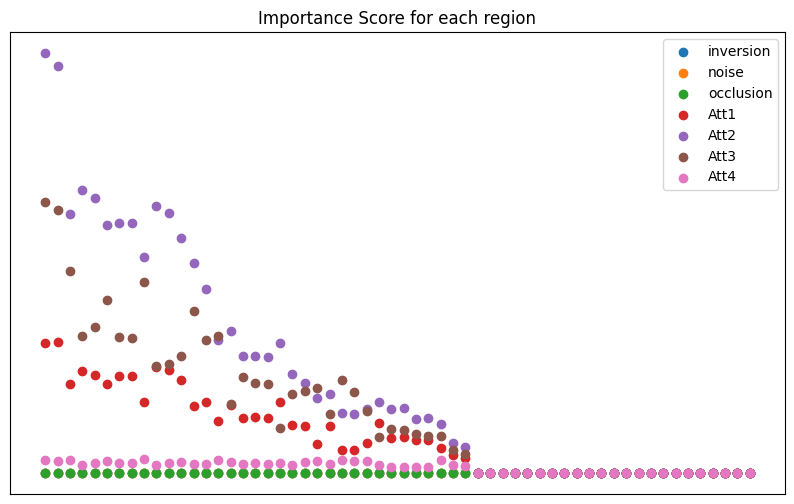

12                   Hippocampus (lh)
51                 pericalcarine (lh)
11                         Brain Stem
27                   Hippocampus (rh)
59          superiorparietal (lh, rh)
50          parstriangularis (lh, rh)
1              Lateral Ventricle (lh)
40              isthmuscingulate (lh)
76                     precuneus (rh)
45            middletemporal (lh, rh)
6                        Caudate (lh)
15                     Accumbens (lh)
43                       lingual (lh)
4              Cerebellar Cortex (lh)
49             parsorbitalis (lh, rh)
48           parsopercularis (lh, rh)
16                    Ventral DC (lh)
10                      4th-Ventricle
52                   postcentral (lh)
9                       3rd-Ventricle
53            posteriorcingulate (lh)
17                Choroid Plexus (lh)
62        transversetemporal (lh, rh)
57      rostralmiddlefrontal (lh, rh)
42          lateralorbitofrontal (lh)
3        Cerebellar White Matter (lh)
30          

In [17]:
df['Average'] = df[['inversion', 'noise', 'occlusion','attention1','attention2','attention3','attention4']].mean(axis=1)

df_filtered = df[df['Average'] != 0].sort_values(by='Average', ascending=False)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Region'], df_filtered['inversion'], label='inversion')
plt.scatter(df_filtered['Region'], df_filtered['noise'], label='noise')
plt.scatter(df_filtered['Region'], df_filtered['occlusion'], label='occlusion')
plt.scatter(df_filtered['Region'], df_filtered['attention1'], label='Att1')
plt.scatter(df_filtered['Region'], df_filtered['attention2'], label='Att2')
plt.scatter(df_filtered['Region'], df_filtered['attention3'], label='Att3')
plt.scatter(df_filtered['Region'], df_filtered['attention4'], label='Att4')
# plt.xlabel('Region')
# plt.ylabel('Importance Score')
plt.title('Importance Score for each region')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()
print(df_filtered['Region'])

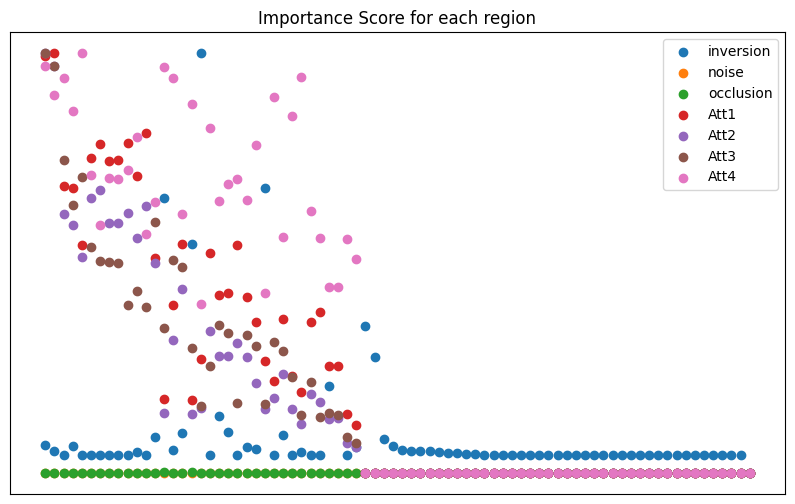

12                   Hippocampus (lh)
51                 pericalcarine (lh)
11                         Brain Stem
50          parstriangularis (lh, rh)
76                     precuneus (rh)
                   ...               
34       caudalmiddlefrontal (lh, rh)
29                     Accumbens (rh)
19             Lateral Ventricle (rh)
20    Inferior Lateral Ventricle (rh)
0          Cortical white matter (lh)
Name: Region, Length: 78, dtype: object


In [20]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['inversion','attention1','attention2','attention3','attention4']

scaler = MinMaxScaler()

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df['Average'] = df[['inversion', 'noise', 'occlusion','attention1','attention2','attention3','attention4']].mean(axis=1)

df_filtered = df[df['Average'] != 0].sort_values(by='Average', ascending=False)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Region'], df_filtered['inversion'], label='inversion')
plt.scatter(df_filtered['Region'], df_filtered['noise'], label='noise')
plt.scatter(df_filtered['Region'], df_filtered['occlusion'], label='occlusion')
plt.scatter(df_filtered['Region'], df_filtered['attention1'], label='Att1')
plt.scatter(df_filtered['Region'], df_filtered['attention2'], label='Att2')
plt.scatter(df_filtered['Region'], df_filtered['attention3'], label='Att3')
plt.scatter(df_filtered['Region'], df_filtered['attention4'], label='Att4')
# plt.xlabel('Region')
# plt.ylabel('Importance Score')
plt.title('Importance Score for each region')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()
print(df_filtered['Region'])

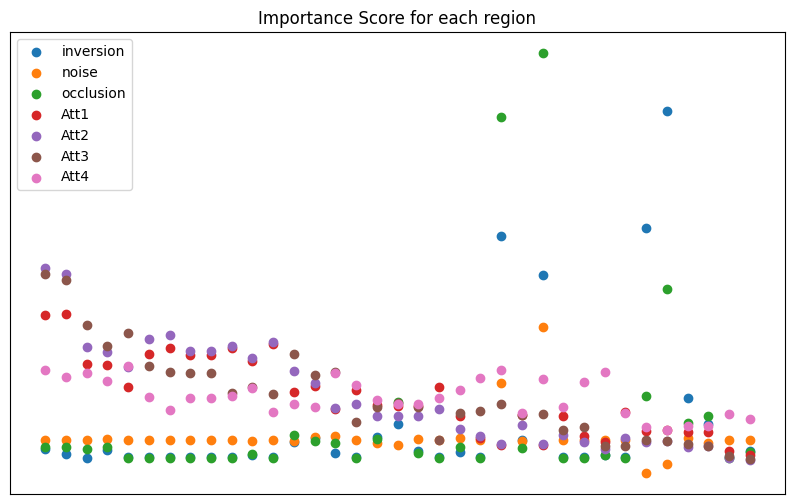

12             Hippocampus (lh)
51           pericalcarine (lh)
11                   Brain Stem
50    parstriangularis (lh, rh)
76               precuneus (rh)
59    superiorparietal (lh, rh)
27             Hippocampus (rh)
40        isthmuscingulate (lh)
1        Lateral Ventricle (lh)
6                  Caudate (lh)
Name: Region, dtype: object


In [21]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['inversion','attention1','attention2','attention3','attention4','noise','occlusion']

scaler = MinMaxScaler()

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# df['Average'] = df[['inversion', 'noise', 'occlusion','attention1','attention2','attention3','attention4']].mean(axis=1)



column_sums = df[columns_to_normalize].sum()

df[columns_to_normalize] = df[columns_to_normalize].divide(column_sums, axis=1)

df['Average'] = df[['attention1','attention2','attention3','attention4']].mean(axis=1)

df_filtered = df[df['Average'] != 0].sort_values(by='Average', ascending=False)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['Region'], df_filtered['inversion'], label='inversion')
plt.scatter(df_filtered['Region'], df_filtered['noise'], label='noise')
plt.scatter(df_filtered['Region'], df_filtered['occlusion'], label='occlusion')
plt.scatter(df_filtered['Region'], df_filtered['attention1'], label='Att1')
plt.scatter(df_filtered['Region'], df_filtered['attention2'], label='Att2')
plt.scatter(df_filtered['Region'], df_filtered['attention3'], label='Att3')
plt.scatter(df_filtered['Region'], df_filtered['attention4'], label='Att4')
# plt.xlabel('Region')
# plt.ylabel('Importance Score')
plt.title('Importance Score for each region')
plt.legend()
plt.xticks([])
plt.yticks([])
plt.show()
print(df_filtered['Region'].head(10))

In [62]:
# 为每个注意力指标分别计算排名
for col in ['attention1', 'attention2', 'attention3', 'attention4']:
    df[col + '_rank'] = df[col].rank(ascending=False)

# 计算综合排名
df['final_rank'] = df[['attention1_rank', 'attention2_rank', 'attention3_rank', 'attention4_rank']].mean(axis=1)

# 根据综合排名排序
df_sorted = df.sort_values(by='final_rank')
print(df_sorted['Region'].head(10))

12             Hippocampus (lh)
51           pericalcarine (lh)
11                   Brain Stem
76               precuneus (rh)
59    superiorparietal (lh, rh)
50    parstriangularis (lh, rh)
6                  Caudate (lh)
27             Hippocampus (rh)
1        Lateral Ventricle (lh)
40        isthmuscingulate (lh)
Name: Region, dtype: object


In [63]:
df

,Region,Fastsurfer,Freefurfer,Group,inversion,noise,occlusion,attention1,attention2,attention3,attention4,attention1_rank,attention2_rank,attention3_rank,attention4_rank,final_rank
0,Cortical white matter (lh),1,2,subcortical,-4.708864e-05,-5.202635e-10,-5.495912e-05,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
1,Lateral Ventricle (lh),2,4,subcortical,-1.613261e-16,9.489054e-22,5.763593e-17,0.515429,1.327640,0.721151,0.051646,8.0,9.0,10.0,17.0,11.00
2,Inferior Lateral Ventricle (lh),3,5,subcortical,6.909541e-04,-1.122941e-08,2.195676e-04,0.184516,0.339804,0.234818,0.031600,26.0,27.0,28.0,34.0,28.75
3,Cerebellar White Matter (lh),4,7,subcortical,5.472695e-04,3.827098e-08,1.449810e-03,0.121229,0.315292,0.428359,0.064720,33.0,30.0,22.0,9.0,23.50
4,Cerebellar Cortex (lh),5,8,subcortical,5.731696e-05,8.354243e-10,6.131670e-05,0.378696,0.978281,0.704543,0.045293,12.0,14.0,12.0,25.0,15.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,postcentral (rh),74,2022,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
74,posteriorcingulate (rh),75,2023,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
75,precentral (rh),76,2024,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
76,precuneus (rh),77,2025,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.377462,1.149138,1.013136,0.073578,13.0,12.0,4.0,1.0,7.50


## Weight evaluation

In [ ]:
       # 生成扰动
        perturbed_sample = np.copy(data)
        if method=='noise':      # adding noise
            perturbation = np.random.normal(0, 0.1, data.shape)
            for region in region_to_perturb:
                perturbed_sample[mask == region] += np.random.normal(0,0.1,perturbed_sample[mask == region].shape)
        elif method=='occlusion': # remove the certain area
            for region in region_to_perturb:
                perturbed_sample[mask == region] =0
        elif method=='blurring': # Apply 3d gaussian flur
            for region in region_to_perturb:
                apply_3d_gaussian_blur_on_region(perturbed_sample,mask,region)
        elif method== 'inversion':
            for region in region_to_perturb:
                perturbed_sample[mask == region] = 255 - perturbed_sample[mask == region]

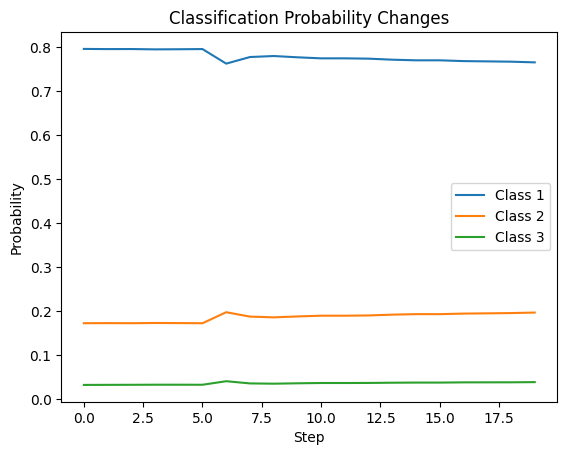

In [64]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt


file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()


# 根据'attention1'列的值进行降序排序
df_sorted = df.sort_values(by='attention1', ascending=False)
df_sorted=df_sorted.head(20)

# 预测结果存储
predictions = []

modified_image = image_data

# 循环处理每个区域
for index, row in df_sorted.iterrows():
    region_number = row['Fastsurfer']  # 获取区域序号
    # 将对应区域归零
    # modified_image = image_data.copy()
    modified_image[mask_data == region_number] = 255 - modified_image[mask_data == region_number]

    input_tensor = torch.tensor(modified_image[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
    
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predictions.append(probabilities.cpu().detach().numpy())

predictions_array = np.array(predictions).squeeze()
plt.plot(predictions_array)
plt.xlabel('Step')
plt.ylabel('Probability')
plt.title('Classification Probability Changes')
plt.legend(['Class 1', 'Class 2', 'Class 3'])
plt.show()


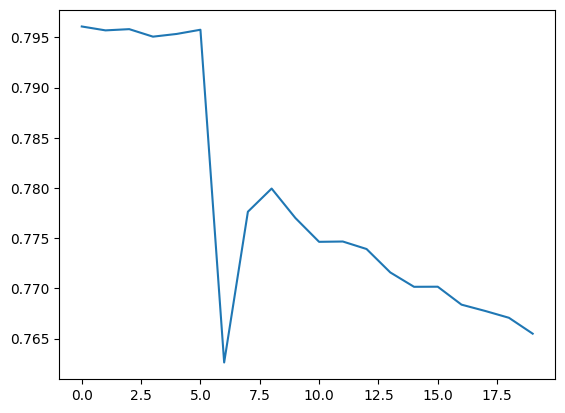

In [53]:
plt.plot(predictions_array[:, 0])

In [57]:
for col in ['attention1', 'attention2', 'attention3', 'attention4']:
    df[col + '_rank'] = df[col].rank(ascending=False)

# 计算综合排名
df['final_rank'] = df[['attention1_rank', 'attention2_rank', 'attention3_rank', 'attention4_rank']].mean(axis=1)


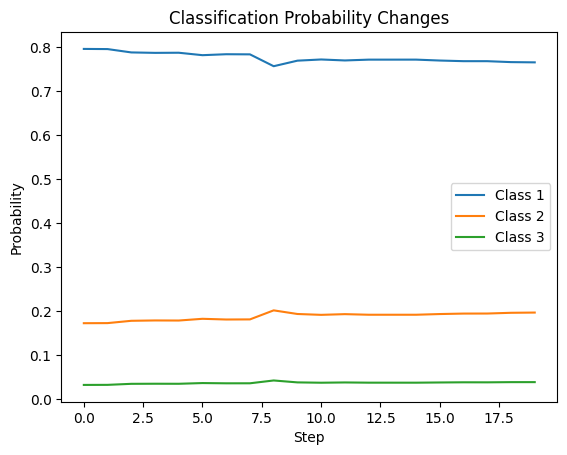

In [61]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()

df_sorted = df.sort_values(by='final_rank', ascending=True)
df_sorted=df_sorted.head(20)

# 预测结果存储
predictions = []

modified_image = image_data

for index, row in df_sorted.iterrows():
    region_number = row['Fastsurfer']  # 获取区域序号
    # modified_image = image_data.copy()
    modified_image[mask_data == region_number] = 255 - modified_image[mask_data == region_number]
    
    input_tensor = torch.tensor(modified_image[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
    

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predictions.append(probabilities.cpu().detach().numpy())

predictions_array = np.array(predictions).squeeze()
plt.plot(predictions_array)
plt.xlabel('Step')
plt.ylabel('Probability')
plt.title('Classification Probability Changes')
plt.legend(['Class 1', 'Class 2', 'Class 3'])
plt.show()


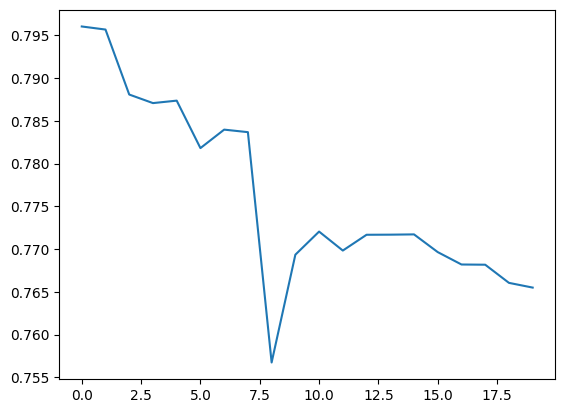

In [63]:
plt.plot(predictions_array[:, 0])

In [82]:
df_sorted['Region']

12             Hippocampus (lh)
51           pericalcarine (lh)
11                   Brain Stem
76               precuneus (rh)
59    superiorparietal (lh, rh)
50    parstriangularis (lh, rh)
6                  Caudate (lh)
27             Hippocampus (rh)
1        Lateral Ventricle (lh)
40        isthmuscingulate (lh)
15               Accumbens (lh)
49       parsorbitalis (lh, rh)
45      middletemporal (lh, rh)
43                 lingual (lh)
4        Cerebellar Cortex (lh)
48     parsopercularis (lh, rh)
10                4th-Ventricle
16              Ventral DC (lh)
9                 3rd-Ventricle
52             postcentral (lh)
Name: Region, dtype: object

In [83]:
predictions = []
input_tensor = torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predictions.append(probabilities.cpu().detach().numpy())

In [87]:
probabilities.cpu().detach().numpy().tolist()[0][0]

0.7965605854988098

In [112]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()


predictions = np.zeros((5,21))
input_tensor = torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)

target_weight=['final_rank','attention1', 'attention2', 'attention3', 'attention4']


for i in range(5):
    predictions[i][0]=probabilities.cpu().detach().numpy().tolist()[0][0]
    
for i in range(5):
    j=1
    if i==0:
        df_sorted = df.sort_values(by=target_weight[i], ascending=True)
    else:
        df_sorted = df.sort_values(by=target_weight[i], ascending=False)
    df_sorted=df_sorted.head(20)

    modified_image = image_data
    
    for index, row in df_sorted.iterrows():
        region_number = row['Fastsurfer']  # 获取区域序号
        # modified_image = image_data.copy()
        modified_image[mask_data == region_number] = 255 - modified_image[mask_data == region_number]
        
        input_tensor = torch.tensor(modified_image[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
        
    
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predictions[i][j]=probabilities.cpu().detach().numpy().tolist()[0][0]
        j+=1


In [113]:
available_styles = plt.style.available
print(available_styles)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


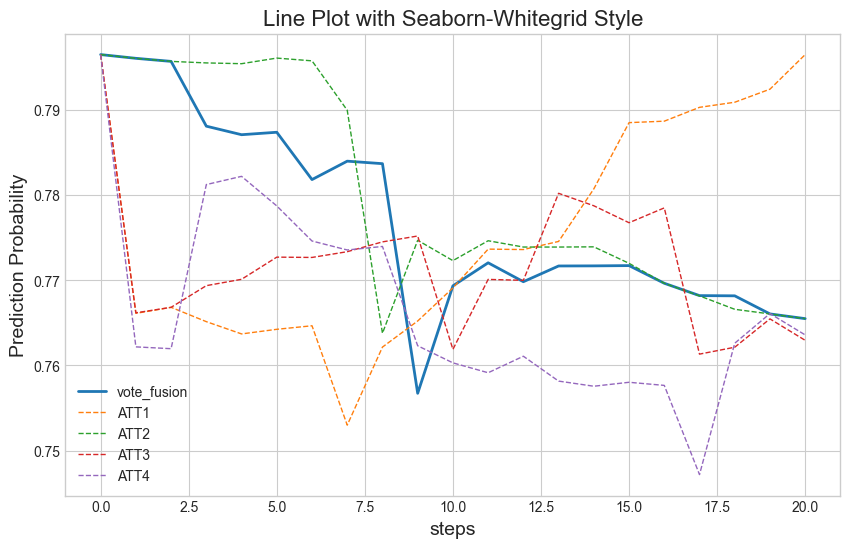

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn

data = predictions 

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

line_names = ['vote_fusion', 'ATT1', 'ATT2', 'ATT3', 'ATT4']
line_styles = ['-', '--', '--', '--', '--']
linewidths=[2,1,1,1,1]

for i in range(data.shape[0]):
    plt.plot(data[i, :], label=line_names[i], linewidth=linewidths[i],linestyle=line_styles[i])
plt.legend()

plt.title('Line Plot with Seaborn-Whitegrid Style', fontsize=16)
plt.xlabel('steps', fontsize=14)
plt.ylabel('Prediction Probability', fontsize=14)

plt.show()



In [110]:
df

,Region,Fastsurfer,Freefurfer,Group,inversion,noise,occlusion,attention1,attention2,attention3,attention4,attention1_rank,attention2_rank,attention3_rank,attention4_rank,final_rank
0,Cortical white matter (lh),1,2,subcortical,-4.708864e-05,-5.202635e-10,-5.495912e-05,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
1,Lateral Ventricle (lh),2,4,subcortical,-1.613261e-16,9.489054e-22,5.763593e-17,0.515429,1.327640,0.721151,0.051646,8.0,9.0,10.0,17.0,11.00
2,Inferior Lateral Ventricle (lh),3,5,subcortical,6.909541e-04,-1.122941e-08,2.195676e-04,0.184516,0.339804,0.234818,0.031600,26.0,27.0,28.0,34.0,28.75
3,Cerebellar White Matter (lh),4,7,subcortical,5.472695e-04,3.827098e-08,1.449810e-03,0.121229,0.315292,0.428359,0.064720,33.0,30.0,22.0,9.0,23.50
4,Cerebellar Cortex (lh),5,8,subcortical,5.731696e-05,8.354243e-10,6.131670e-05,0.378696,0.978281,0.704543,0.045293,12.0,14.0,12.0,25.0,15.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,postcentral (rh),74,2022,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
74,posteriorcingulate (rh),75,2023,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
75,precentral (rh),76,2024,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
76,precuneus (rh),77,2025,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.377462,1.149138,1.013136,0.073578,13.0,12.0,4.0,1.0,7.50


In [77]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()

df_sorted = df.sort_values(by='final_rank', ascending=True)
df_sorted=df_sorted.head(20)

# 预测结果存储
predictions = []
input_tensor = torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predictions.append(probabilities.cpu().detach().numpy())


modified_image = image_data

for index, row in df_sorted.iterrows():
    region_number = row['Fastsurfer']  # 获取区域序号
    # modified_image = image_data.copy()
    modified_image[mask_data == region_number] +=  np.random.normal(0,10,modified_image[mask_data == region_number].shape)
    input_tensor = torch.tensor(modified_image[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
    

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predictions.append(probabilities.cpu().detach().numpy())

predictions=np.array(predictions).squeeze()

In [78]:
modified_predictions = predictions[1:] * (1 - predictions[1:])

first_row_product = predictions[0] * (1 - predictions[0])

ratios = modified_predictions / first_row_product

log_ratios = np.log(ratios)

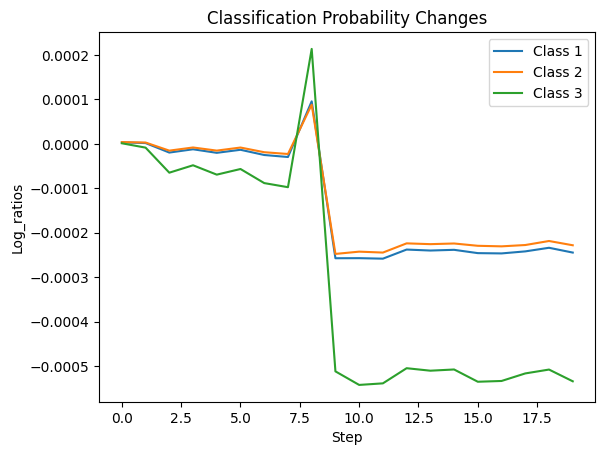

In [81]:
plt.plot(log_ratios)
plt.xlabel('Step')
plt.ylabel('Log_ratios')
plt.title('Classification Probability Changes')
plt.legend(['Class 1', 'Class 2', 'Class 3'])
plt.show()

## Attention Visulization

In [7]:
import torch.nn.functional as F

class ModifiedR3D18(nn.Module):
    def __init__(self, original_model):
        super(ModifiedR3D18, self).__init__()
        # 将原始模型的所有层复制过来
        self.stem = original_model.stem
        self.layer1 = original_model.layer1
        self.layer2 = original_model.layer2
        self.layer3 = original_model.layer3
        self.layer4 = original_model.layer4
        self.avgpool = original_model.avgpool
        self.fc = original_model.fc

        # 初始化一个字典来保存特征图
        self.feature_maps = {}
        self.attention_weights = {}
        
    def forward(self, x):
        # 逐层前向传播，同时保存特征图
        x = self.stem(x)
        self.feature_maps['stem'] = x

        x = self.layer1(x)
        self.feature_maps['layer1'] = x

        x = self.layer2(x)
        self.feature_maps['layer2'] = x

        x = self.layer3(x)
        self.feature_maps['layer3'] = x

        x = self.layer4(x)
        self.feature_maps['layer4'] = x

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        for name, module in self.named_modules():
            if isinstance(module, SEBasicBlock):
                self.attention_weights[name] = module.get_attention_weight()

        return x


In [8]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\082_S_6690.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

# mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\082_S_6690.nii'  # Please replace with your file path
# mri_mask = nib.load(mask_path)
# mask_data = mri_mask.get_fdata()

mask_data = mask_evenly


modified_model = ModifiedR3D18(model).to(device)
output = modified_model(torch.tensor(input_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device))

In [9]:
n=4
feature_maps = modified_model.feature_maps['layer%s'%n]  # 特征图
attention_weights = modified_model.attention_weights['layer%s.0'%n]  # 以此类推

expanded_attention_weights = attention_weights.expand_as(feature_maps)

weighted_feature_maps = feature_maps * expanded_attention_weights

upsampled_feature_maps = F.interpolate(
    weighted_feature_maps,
    size=(256, 256, 256),
    mode='trilinear',
    align_corners=True
)

heatmap = torch.mean(upsampled_feature_maps, dim=1).squeeze()

heatmap = heatmap.cpu().detach().numpy()

results = []
for region_id in range(1, 512):
    region_mask = mask_data == region_id
    average_value = heatmap[region_mask].mean()
    results.append({'Region ID': region_id, 'Average Value': average_value})
df = pd.DataFrame(results)

df_sorted = df.sort_values(by='Region ID')
df_sorted.fillna(0).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\082_S_6690_ATT%s.csv'%n,index=None)
print('Done')

Done


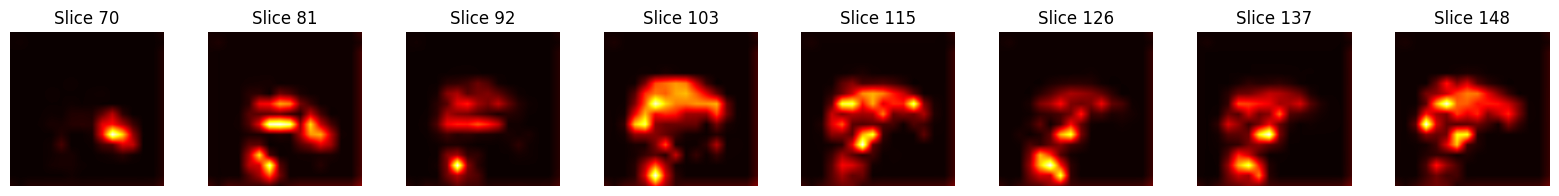

In [7]:
import matplotlib.pyplot as plt
import numpy as np

start_slice = 70
end_slice = 160
num_slices = 8

slices_indices = np.linspace(start_slice, end_slice, num_slices, endpoint=False, dtype=int)

fig, axes = plt.subplots(1, num_slices, figsize=(20, 2))

for i, idx in enumerate(slices_indices):
    axes[i].imshow(heatmap[idx, :, :], cmap='hot')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

plt.show()
fig.savefig(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_attlayer4.png', dpi=500) 

In [9]:
attention_results=pd.DataFrame()
for i in range(1,5):
    feature_maps = modified_model.feature_maps['layer%s'%i]  # 特征图
    attention_weights = modified_model.attention_weights['layer%s.0'%i]  # 以此类推
    
    expanded_attention_weights = attention_weights.expand_as(feature_maps)
    
    weighted_feature_maps = feature_maps * expanded_attention_weights
    
    upsampled_feature_maps = F.interpolate(
        weighted_feature_maps,
        size=(256, 256, 256),
        mode='trilinear',
        align_corners=True
    )
    heatmap = torch.mean(upsampled_feature_maps, dim=1).squeeze()
    heatmap = heatmap.cpu().detach().numpy()
    
    results = []
    for region_id in range(1, 79):
        region_mask = mask_data == region_id
        average_value = heatmap[region_mask].mean()
        results.append({'Region ID': region_id, 'Average Value': average_value})
    df = pd.DataFrame(results)
    
    df_sorted = df.sort_values(by='Region ID')
    attention_results=pd.concat([attention_results,df_sorted.fillna(0)])
print('Done')

C:\Users\duson\AppData\Local\Temp\ipykernel_18528\2347470649.py:22: RuntimeWarning: Mean of empty slice.
  average_value = heatmap[region_mask].mean()
C:\Users\duson\.conda\envs\pytorch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 GiB. GPU 0 has a total capacty of 23.99 GiB of which 0 bytes is free. Of the allocated memory 25.11 GiB is allocated by PyTorch, and 205.36 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Visualize the model

In [ ]:
from torchsummary import summary

summary(model,(1,256,256,256),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 64, 256, 128, 128]           9,408
       BatchNorm3d-2    [-1, 64, 256, 128, 128]             128
              ReLU-3    [-1, 64, 256, 128, 128]               0
            Conv3d-4    [-1, 64, 256, 128, 128]         110,592
       BatchNorm3d-5    [-1, 64, 256, 128, 128]             128
              ReLU-6    [-1, 64, 256, 128, 128]               0
            Conv3d-7    [-1, 64, 256, 128, 128]         110,592
       BatchNorm3d-8    [-1, 64, 256, 128, 128]             128
 AdaptiveAvgPool3d-9          [-1, 64, 1, 1, 1]               0
           Linear-10                    [-1, 4]             256
             ReLU-11                    [-1, 4]               0
           Linear-12                   [-1, 64]             256
          Sigmoid-13                   [-1, 64]               0
          SEBlock-14    [-1, 64, 256, 1

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])


### GradCam

In [ ]:
def save_features(module, input, output):
    module.saved_features = output
def save_gradients(module, input, output):
    module.saved_gradients = input[0]
# 假设 target_layer 是您选择进行可视化的层
target_layer = model.layer4[0]  # 例如，选择 model.layer4 的第一个子模块

# 注册钩子
target_layer.register_forward_hook(save_features)
target_layer.register_backward_hook(save_gradients)


In [ ]:
# 前向传播
input_tensor = torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device) # 您的输入张量，形状为 [1, C, D, H, W]
input_tensor.requires_grad_(True)

# 如果模型在评估模式下，切换到训练模式
model.eval()

# 执行前向传播
output = model(input_tensor)

# 获取目标类别的输出
target_class = 0 # 目标类别的索引
target = output[0, target_class]

# 反向传播以获取目标类别相对于目标层输出的梯度
model.zero_grad()
target.backward()

In [ ]:
features = target_layer.saved_features
gradients = target_layer.saved_gradients
print(features.shape)
print(gradients.shape)

In [ ]:
# 获取特征图和梯度
features = features[0]  # 从 [1, 512, 32, 16, 16] 到 [512, 32, 16, 16]
gradients = gradients[0]  # 从 [1, 512, 32, 16, 16] 到 [512, 32, 16, 16]

# 计算每个通道的权重（全局平均池化）
weights = torch.mean(gradients, dim=[1, 2, 3])  # 在空间维度上计算平均值

# 生成热力图
gcam = torch.zeros_like(features[0]).to(device)  # 初始化热力图
for i, w in enumerate(weights):
    gcam += w * features[i]

# ReLU on top of the heatmap
gcam = F.relu(gcam)

# 热力图归一化处理
gcam -= gcam.min()
gcam /= gcam.max()

# 上采样到原始图像的大小
# 假设原始图像的大小是 [D, H, W]，您需要将这个尺寸提供给代码
original_size = (256, 256, 256)  # 替换为您的原始尺寸
gcam = F.interpolate(gcam.unsqueeze(0).unsqueeze(0), size=original_size, mode='trilinear', align_corners=False).squeeze()

# 现在 gcam 是一个 [D, H, W] 形状的3D热力图


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

start_slice = 70
end_slice = 160
num_slices = 8
gcam_np=gcam.cpu().detach().numpy()
slices_indices = np.linspace(start_slice, end_slice, num_slices, endpoint=False, dtype=int)

fig, axes = plt.subplots(1, num_slices, figsize=(20, 2))

for i, idx in enumerate(slices_indices):
    axes[i].imshow(gcam_np[idx, :, :], cmap='hot')
    axes[i].set_title(f'Slice {idx}')
    axes[i].axis('off')

plt.show()


### generate overlap demo

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
mapping=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\brain_structures.csv')
df_inversion=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_inversion.csv').iloc[2:3,1:].T
df_inversion=-df_inversion
# df_blurring=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_blurring.csv').iloc[2:3,1:].T
df_noise=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_noise.csv').iloc[2:3,1:].T
df_occlusion=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_occlusion.csv').iloc[2:3,1:].T
df_att1=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT1.csv').iloc[:,2:3]
df_att2=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT2.csv').iloc[:,2:3]
df_att3=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT3.csv').iloc[:,2:3]
df_att4=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_ATT4.csv').iloc[:,2:3]

df=pd.concat([mapping,df_inversion.reset_index(drop=True)
                  # ,df_blurring.reset_index(drop=True)
                  ,df_noise.reset_index(drop=True)
                  ,df_occlusion.reset_index(drop=True)
                 ,df_att1.reset_index(drop=True)
                 ,df_att2.reset_index(drop=True)
                 ,df_att3.reset_index(drop=True)
                 ,df_att4.reset_index(drop=True)
                 ],axis=1,ignore_index=True)

df.columns=['Region','Fastsurfer','Freefurfer','Group','inversion','noise','occlusion','attention1','attention2','attention3','attention4']

In [17]:
for col in ['attention1', 'attention2', 'attention3', 'attention4']:
    df[col + '_rank'] = df[col].rank(ascending=False)

# 计算综合排名
df['final_rank'] = df[['attention1_rank', 'attention2_rank', 'attention3_rank', 'attention4_rank']].mean(axis=1)


In [18]:
df

,Region,Fastsurfer,Freefurfer,Group,inversion,noise,occlusion,attention1,attention2,attention3,attention4,attention1_rank,attention2_rank,attention3_rank,attention4_rank,final_rank
0,Cortical white matter (lh),1,2,subcortical,-4.708864e-05,-5.202635e-10,-5.495912e-05,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
1,Lateral Ventricle (lh),2,4,subcortical,-1.613261e-16,9.489054e-22,5.763593e-17,0.515429,1.327640,0.721151,0.051646,8.0,9.0,10.0,17.0,11.00
2,Inferior Lateral Ventricle (lh),3,5,subcortical,6.909541e-04,-1.122941e-08,2.195676e-04,0.184516,0.339804,0.234818,0.031600,26.0,27.0,28.0,34.0,28.75
3,Cerebellar White Matter (lh),4,7,subcortical,5.472695e-04,3.827098e-08,1.449810e-03,0.121229,0.315292,0.428359,0.064720,33.0,30.0,22.0,9.0,23.50
4,Cerebellar Cortex (lh),5,8,subcortical,5.731696e-05,8.354243e-10,6.131670e-05,0.378696,0.978281,0.704543,0.045293,12.0,14.0,12.0,25.0,15.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,postcentral (rh),74,2022,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
74,posteriorcingulate (rh),75,2023,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
75,precentral (rh),76,2024,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
76,precuneus (rh),77,2025,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.377462,1.149138,1.013136,0.073578,13.0,12.0,4.0,1.0,7.50


In [22]:
df.nsmallest(10, 'final_rank')['Region'].tolist()

['Hippocampus (lh)',
 'pericalcarine (lh)',
 'Brain Stem',
 'precuneus (rh)',
 'superiorparietal (lh, rh)',
 'parstriangularis (lh, rh)',
 'Caudate (lh)',
 'Hippocampus (rh)',
 'Lateral Ventricle (lh)',
 'isthmuscingulate (lh)']

In [28]:
target_list

[12, 27, 69, 70, 71, 3, 21, 4, 22, 48, 72, 33, 36, 37, 54, 55]

In [29]:
top_10_important_areas

[13, 52, 12, 77, 60, 51, 7, 28, 2, 41]

{28, 13}


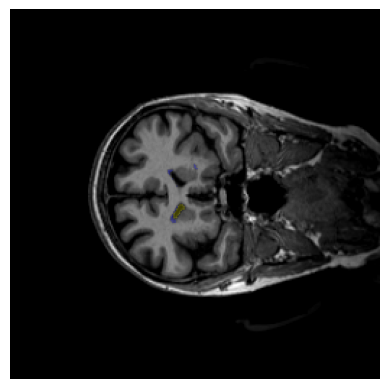

In [37]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

# 加载 MRI 数据和掩膜
mri_data = nib.load(r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii').get_fdata()
brain_mask = nib.load(r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii').get_fdata()

label_to_importance = dict(zip(df['Fastsurfer'], df['inversion']))

# 定义目标区域列表和获取重要性最高的 10 个区域
# target_list = [12,27,69,70,71,3,21,4,22,48,72,33,36,37,54,55]  # 您的目标列表
original_list = [12,27,69,70,71,3,21,4,22,48,72,33,36,37,54,55]  # 您的目标列表
target_list = [x + 1 for x in original_list]
top_10_important_areas = df.nsmallest(8, 'final_rank')['Fastsurfer'].tolist()
set1=set(target_list)
set2=set(top_10_important_areas)
common=set1.intersection(set2)
print(common)


# 染色逻辑
colored_brain = np.zeros(mri_data.shape + (4,))  # 创建一个带透明通道的用于着色的数组

# 对目标区域着色（黄色）
for target in target_list:
    colored_brain[brain_mask == target] = [1, 1, 0, 0.5]  # 黄色，半透明

# 对重要性最高的区域着色（蓝色）
for area in top_10_important_areas:
    colored_brain[brain_mask == area] += [0, 0, 1, 0.5]  # 蓝色，半透明

# 红色覆盖（黄色 + 蓝色）
colored_brain[np.all(colored_brain[:, :, :, :3] >= [1, 1, 1], axis=-1)] = [1, 0, 0, 0.5]  # 红色，半透明

# 修正颜色叠加后可能超出范围的问题
colored_brain = np.clip(colored_brain, 0, 1)

# 切片并保存
def save_colored_slice(mri_slice, colored_slice, axis, slice_number, filename):
    plt.imshow(mri_slice, cmap='gray')
    plt.imshow(colored_slice, alpha=0.5)
    plt.axis('off')
    plt.savefig(f'{filename}_axis_{axis}_slice_{slice_number}.png', bbox_inches='tight', pad_inches=0)

save_path = 'D:\\Juntao\\Data\\2023.12\\results\\'  # 指定保存路径

for axis in range(3):
    for i in range(3):
        slice_index = int(mri_data.shape[axis] // 2 + (i - 1) * mri_data.shape[axis] * 0.1)
        if axis == 0:
            save_colored_slice(mri_data[slice_index, :, :], colored_brain[slice_index, :, :, :], axis, i, save_path + 'colored_brain')
        elif axis == 1:
            save_colored_slice(mri_data[:, slice_index, :], colored_brain[:, slice_index, :, :], axis, i, save_path + 'colored_brain')
        else:
            save_colored_slice(mri_data[:, :, slice_index], colored_brain[:, :, slice_index, :], axis, i, save_path + 'colored_brain')

### Re-segmentation

In [74]:
import numpy as np
import pandas as pd

def subdivide_regions(mask, volume_threshold, skip_id=[0,1]):
    new_region_id = np.max(mask) + 1
    new_mask = mask.copy()
    region_mappings = []

    for region_id in np.unique(mask):
        if region_id in skip_id:
            continue

        region_volume = np.sum(mask == region_id)

        if region_volume > volume_threshold:
            num_subdivisions = int(np.ceil(region_volume / volume_threshold))
            indices = np.argwhere(mask == region_id)
            split_indices = np.array_split(indices, num_subdivisions)

            for subdiv_idx in split_indices:
                for idx in subdiv_idx:
                    new_mask[tuple(idx)] = new_region_id

                region_mappings.append([region_id, new_region_id])
                new_region_id += 1

    return new_mask, pd.DataFrame(region_mappings, columns=['Original_ID', 'New_ID'])


volume_threshold = 4600
new_mask, mappings_df = subdivide_regions(mask_data, volume_threshold)


In [76]:
np.unique(new_mask)

array([  0.,   5.,  11.,  12.,  13.,  14.,  15.,  17.,  18.,  24.,  26.,
        28.,  31.,  44.,  50.,  51.,  52.,  53.,  54.,  58.,  60.,  63.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153.,
       154., 155., 156., 157., 158., 159., 160., 161., 162., 163., 164.,
       165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186.,
       187., 188., 189., 190., 191., 192., 193., 194., 195., 196., 197.,
       198., 199., 200., 201., 202., 203., 204., 20

In [ ]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()

mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_mask = nib.load(mask_path)
mask_data = mri_mask.get_fdata()


predictions = np.zeros((5,201))
input_tensor = torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)

target_weight=['final_rank','attention1', 'attention2', 'attention3', 'attention4']


for i in range(5):
    predictions[i][0]=probabilities.cpu().detach().numpy().tolist()[0][0]
    
for i in range(5):
    j=1
    if i==0:
        df_sorted = df.sort_values(by=target_weight[i], ascending=True)
    else:
        df_sorted = df.sort_values(by=target_weight[i], ascending=False)
    df_sorted=df_sorted.head(200)

    modified_image = image_data
    
    for index, row in df_sorted.iterrows():
        region_number = row['Fastsurfer']  # 获取区域序号
        # modified_image = image_data.copy()
        modified_image[mask_data == region_number] = 255 - modified_image[mask_data == region_number]
        
        input_tensor = torch.tensor(modified_image[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
        
    
        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predictions[i][j]=probabilities.cpu().detach().numpy().tolist()[0][0]
        j+=1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn

data = predictions 

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))

line_names = ['vote_fusion', 'ATT1', 'ATT2', 'ATT3', 'ATT4']
line_styles = ['-', '--', '--', '--', '--']
linewidths=[2,1,1,1,1]

for i in range(data.shape[0]):
    plt.plot(data[i, :], label=line_names[i], linewidth=linewidths[i],linestyle=line_styles[i])
plt.legend()

plt.title('Line Plot with Seaborn-Whitegrid Style', fontsize=16)
plt.xlabel('steps', fontsize=14)
plt.ylabel('Prediction Probability', fontsize=14)

plt.show()



In [77]:
df

,Region,Fastsurfer,Freefurfer,Group,inversion,noise,occlusion,attention1,attention2,attention3,attention4,attention1_rank,attention2_rank,attention3_rank,attention4_rank,final_rank
0,Cortical white matter (lh),1,2,subcortical,-4.708864e-05,-5.202635e-10,-5.495912e-05,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
1,Lateral Ventricle (lh),2,4,subcortical,-1.613261e-16,9.489054e-22,5.763593e-17,0.515429,1.327640,0.721151,0.051646,8.0,9.0,10.0,17.0,11.00
2,Inferior Lateral Ventricle (lh),3,5,subcortical,6.909541e-04,-1.122941e-08,2.195676e-04,0.184516,0.339804,0.234818,0.031600,26.0,27.0,28.0,34.0,28.75
3,Cerebellar White Matter (lh),4,7,subcortical,5.472695e-04,3.827098e-08,1.449810e-03,0.121229,0.315292,0.428359,0.064720,33.0,30.0,22.0,9.0,23.50
4,Cerebellar Cortex (lh),5,8,subcortical,5.731696e-05,8.354243e-10,6.131670e-05,0.378696,0.978281,0.704543,0.045293,12.0,14.0,12.0,25.0,15.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,postcentral (rh),74,2022,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
74,posteriorcingulate (rh),75,2023,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
75,precentral (rh),76,2024,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.0,57.0,57.0,57.0,57.00
76,precuneus (rh),77,2025,cortical,-0.000000e+00,0.000000e+00,0.000000e+00,0.377462,1.149138,1.013136,0.073578,13.0,12.0,4.0,1.0,7.50


In [78]:
mappings_df

,Original_ID,New_ID
0,2.0,78.0
1,2.0,79.0
2,2.0,80.0
3,2.0,81.0
4,2.0,82.0
...,...,...
244,47.0,322.0
245,47.0,323.0
246,47.0,324.0
247,49.0,325.0


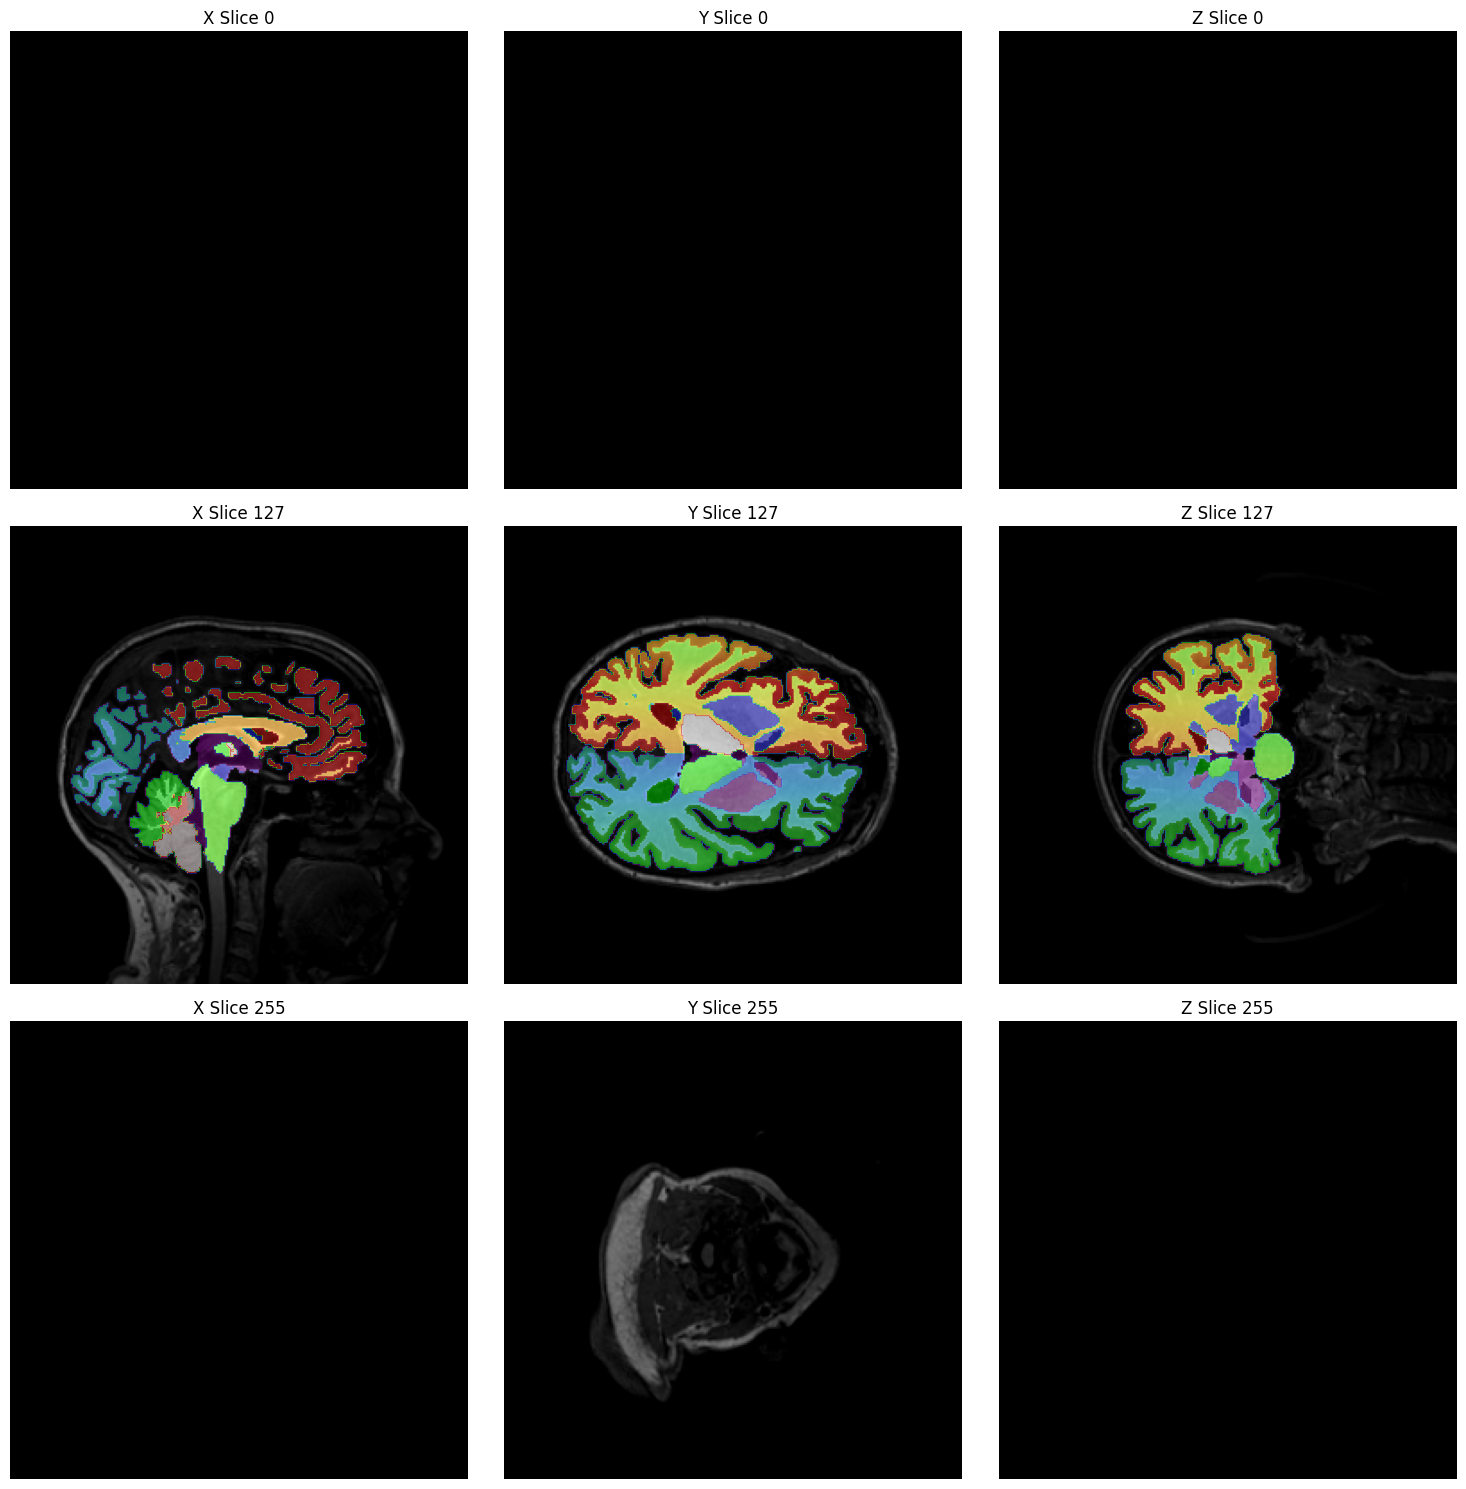

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def plot_slices(mri_img, mask, num_slices=3, num_regions=326):
    x_dim, y_dim, z_dim = mri_img.shape

    x_slices = np.linspace(0, x_dim - 1, num_slices, dtype=int)
    y_slices = np.linspace(0, y_dim - 1, num_slices, dtype=int)
    z_slices = np.linspace(0, z_dim - 1, num_slices, dtype=int)

    cmap = plt.get_cmap('nipy_spectral', num_regions)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, slice_idx in enumerate(x_slices):
        axes[i, 0].imshow(mri_img[slice_idx, :, :], cmap='gray')
        axes[i, 0].imshow(mask[slice_idx, :, :], cmap=cmap, alpha=0.5)
        axes[i, 0].set_title(f'X Slice {slice_idx}')

    for i, slice_idx in enumerate(y_slices):
        axes[i, 1].imshow(mri_img[:, slice_idx, :], cmap='gray')
        axes[i, 1].imshow(mask[:, slice_idx, :], cmap=cmap, alpha=0.5)
        axes[i, 1].set_title(f'Y Slice {slice_idx}')

    for i, slice_idx in enumerate(z_slices):
        axes[i, 2].imshow(mri_img[:, :, slice_idx], cmap='gray')
        axes[i, 2].imshow(mask[:, :, slice_idx], cmap=cmap, alpha=0.5)
        axes[i, 2].set_title(f'Z Slice {slice_idx}')

    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

mri_img = image_data
mask = new_mask
plot_slices(mri_img, mask)


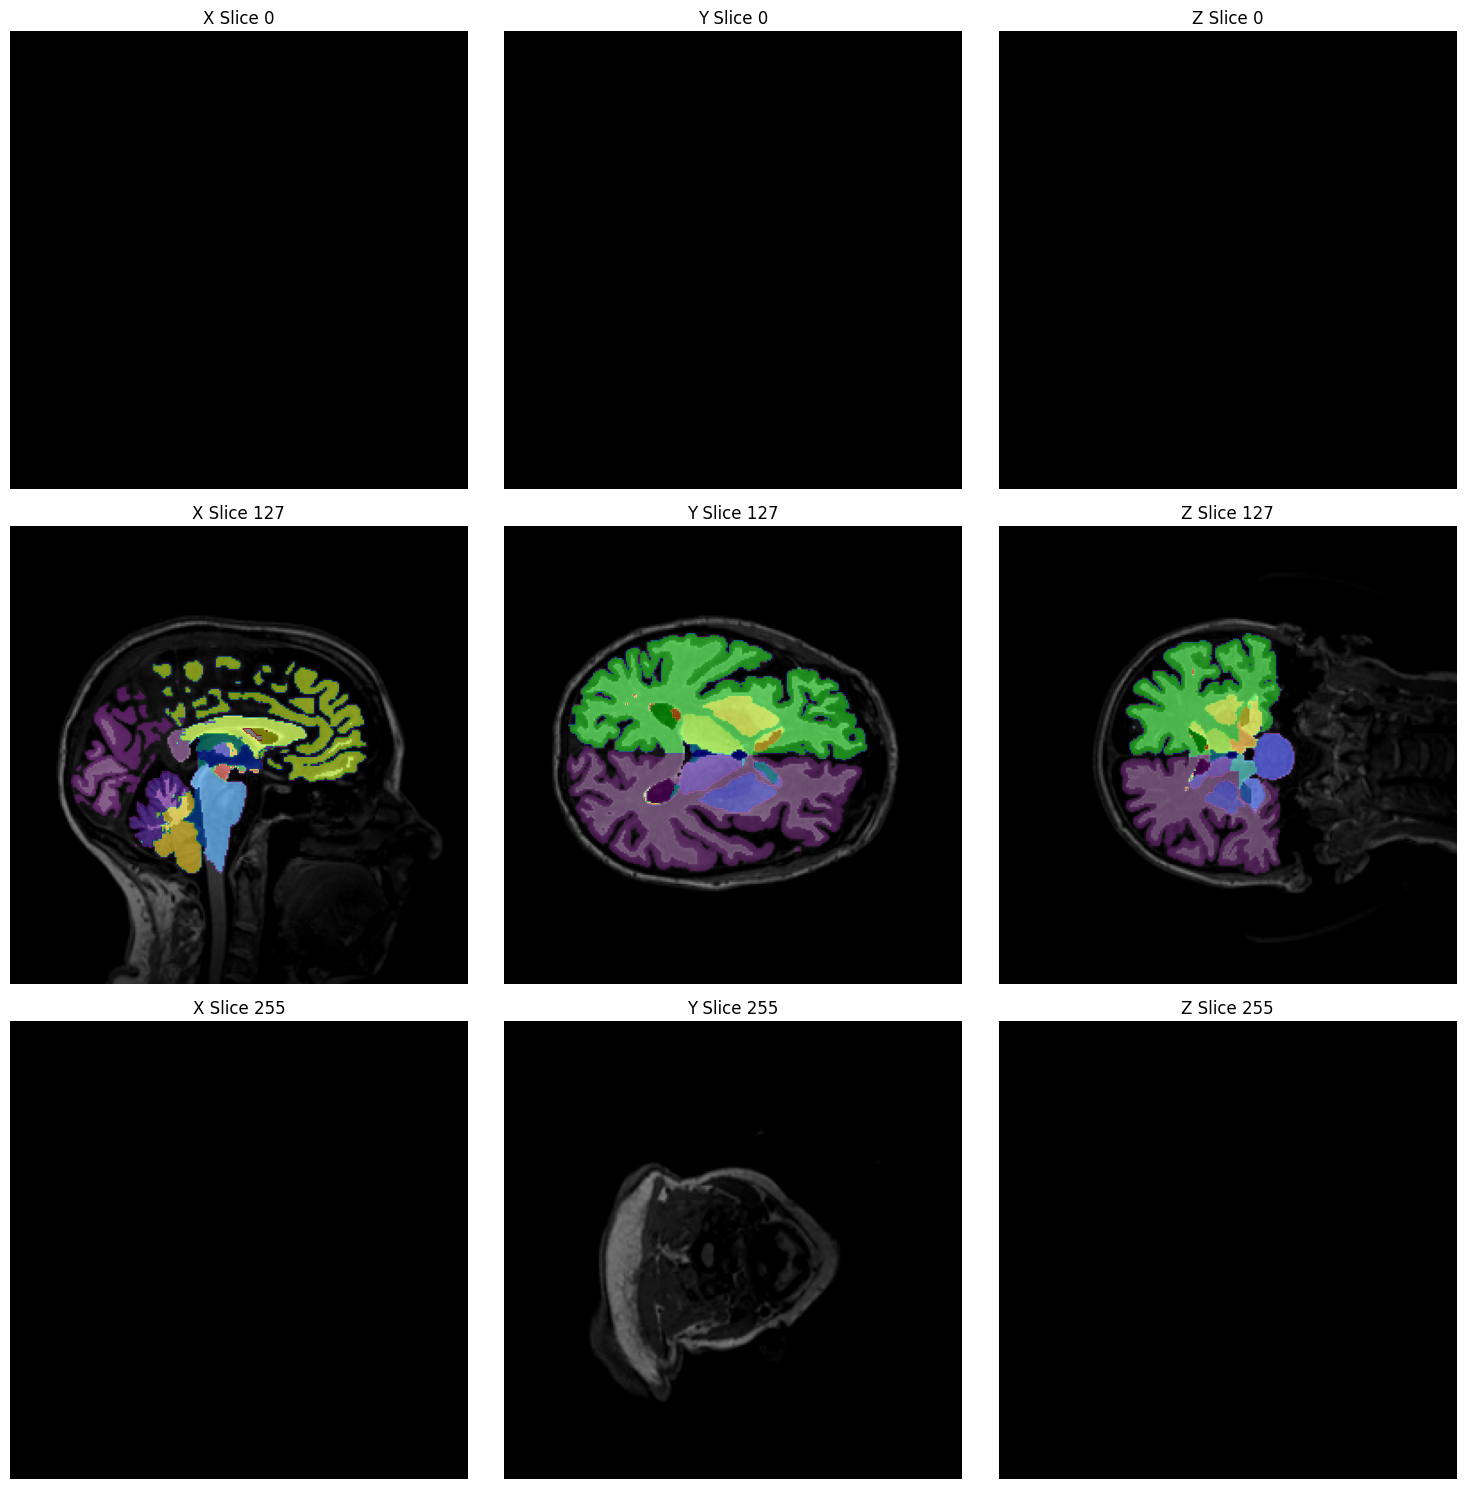

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def plot_slices(mri_img, mask, num_slices=3, num_regions=326):
    x_dim, y_dim, z_dim = mri_img.shape

    x_slices = np.linspace(0, x_dim - 1, num_slices, dtype=int)
    y_slices = np.linspace(0, y_dim - 1, num_slices, dtype=int)
    z_slices = np.linspace(0, z_dim - 1, num_slices, dtype=int)

    cmap = plt.get_cmap('nipy_spectral', num_regions)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i, slice_idx in enumerate(x_slices):
        axes[i, 0].imshow(mri_img[slice_idx, :, :], cmap='gray')
        axes[i, 0].imshow(mask[slice_idx, :, :], cmap=cmap, alpha=0.5)
        axes[i, 0].set_title(f'X Slice {slice_idx}')

    for i, slice_idx in enumerate(y_slices):
        axes[i, 1].imshow(mri_img[:, slice_idx, :], cmap='gray')
        axes[i, 1].imshow(mask[:, slice_idx, :], cmap=cmap, alpha=0.5)
        axes[i, 1].set_title(f'Y Slice {slice_idx}')

    for i, slice_idx in enumerate(z_slices):
        axes[i, 2].imshow(mri_img[:, :, slice_idx], cmap='gray')
        axes[i, 2].imshow(mask[:, :, slice_idx], cmap=cmap, alpha=0.5)
        axes[i, 2].set_title(f'Z Slice {slice_idx}')

    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

mri_img = image_data
mask = new_mask
plot_slices(mri_img, mask_data)


In [81]:
df.to_csv(r'D:\Juntao\Data\ANDI3-T1\results\importance_order_by_attention.csv')

## Regenerate the Mask

In [6]:
import numpy as np

def generate_mask(dimensions, cube_size):

    # Calculate the number of cubes along each dimension
    cubes_per_dim = [dimension // cube_size for dimension in dimensions]

    # Initialize the mask with zeros
    mask = np.zeros(dimensions, dtype=int)

    # Counter for the unique numbers
    unique_number = 1

    # Fill in each cube with a unique number
    for x in range(cubes_per_dim[0]):
        for y in range(cubes_per_dim[1]):
            for z in range(cubes_per_dim[2]):
                start_x, end_x = x * cube_size, (x + 1) * cube_size
                start_y, end_y = y * cube_size, (y + 1) * cube_size
                start_z, end_z = z * cube_size, (z + 1) * cube_size
                mask[start_x:end_x, start_y:end_y, start_z:end_z] = unique_number
                unique_number += 1

    return mask

# Generate the mask for the MRI image
mri_dimensions = (256, 256, 256)
cube_size = 32
mask_evenly = generate_mask(mri_dimensions, cube_size)

# Checking the unique values in the mask
unique_values = np.unique(mask_evenly)
print("Unique values in the mask:", unique_values)


Unique values in the mask: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240

In [11]:
file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\082_S_6690.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
input_data = mri_image.get_fdata()

for method in ['noise','inversion']:
# for method in ['blurring','inversion']:
    X, Y = generate_perturbations(input_data,mask,model, 100,method)
    Y=np.array(Y)
    
    regressor0 = LinearRegression()
    regressor1 = LinearRegression()
    regressor2 = LinearRegression()
    regressor0.fit(np.array(X)*v_vector, Y[:,0])
    regressor1.fit(np.array(X)*v_vector, Y[:,1])
    regressor2.fit(np.array(X)*v_vector, Y[:,2])

    pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\2023.12\results\082_S_6690_%s.csv'%method,index=None)

# print(regressor0.coef_)
# print(regressor1.coef_)
# print(regressor2.coef_)

# pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,79)).to_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_%s.csv'%method)

non zero regions: 512
0
10
20
30
40
50
60
70
80
90


NameError: name 'v_vector' is not defined

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# mapping=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\brain_structures.csv')
# df_inversion=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_inversion.csv').iloc[2:3,1:].T
# df_inversion=-df_inversion
# # df_blurring=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_blurring.csv').iloc[2:3,1:].T
# df_noise=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_noise.csv').iloc[2:3,1:].T
# df_occlusion=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\041_S_6226_occlusion.csv').iloc[2:3,1:].T
df_att1=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\082_S_6690_ATT1.csv').iloc[:,0:2]
df_att2=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\082_S_6690_ATT2.csv').iloc[:,1:2]
df_att3=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\082_S_6690_ATT3.csv').iloc[:,1:2]
df_att4=pd.read_csv(r'D:\Juntao\Data\ANDI3-T1\results\082_S_6690_ATT4.csv').iloc[:,1:2]

df=pd.concat([df_att1.reset_index(drop=True)
                 ,df_att2.reset_index(drop=True)
                 ,df_att3.reset_index(drop=True)
                 ,df_att4.reset_index(drop=True)
                 ],axis=1,ignore_index=True)

df.columns=['Region_ID','attention1','attention2','attention3','attention4']

In [16]:
for col in ['attention1', 'attention2', 'attention3', 'attention4']:
    df[col + '_rank'] = df[col].rank(ascending=False)

# 计算综合排名
df['final_rank'] = df[['attention1_rank', 'attention2_rank', 'attention3_rank', 'attention4_rank']].mean(axis=1)

# 根据综合排名排序
df_sorted = df.sort_values(by='final_rank')
print(df_sorted['Region_ID'].head(10))

305    306
365    366
241    242
173    174
250    251
370    371
242    243
373    374
306    307
172    173
Name: Region_ID, dtype: int64


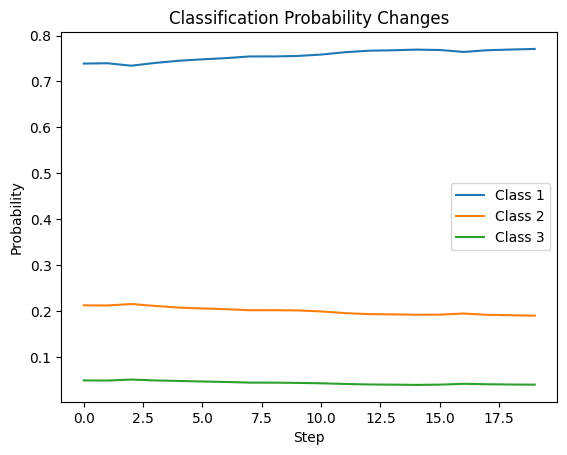

In [17]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt


file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\082_S_6690.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()

# mask_path = r'D:\Juntao\Data\ANDI3-T1\auto_noCCseg\082_S_6690.nii'  # Please replace with your file path
# mri_mask = nib.load(mask_path)
# mask_data = mri_mask.get_fdata()

mask_data=mask_evenly


# 根据'attention1'列的值进行降序排序
df_sorted = df.sort_values(by='attention1', ascending=False)
df_sorted=df_sorted.head(100)

# 预测结果存储
predictions = []

modified_image = image_data

# 循环处理每个区域
for index, row in df_sorted.iterrows():
    region_number = row['Region_ID']  # 获取区域序号
    # 将对应区域归零
    # modified_image = image_data.copy()
    modified_image[mask_data == region_number] = 255 - modified_image[mask_data == region_number]

    input_tensor = torch.tensor(modified_image[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)  
    
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predictions.append(probabilities.cpu().detach().numpy())

predictions_array = np.array(predictions).squeeze()
plt.plot(predictions_array)
plt.xlabel('Step')
plt.ylabel('Probability')
plt.title('Classification Probability Changes')
plt.legend(['Class 1', 'Class 2', 'Class 3'])
plt.show()


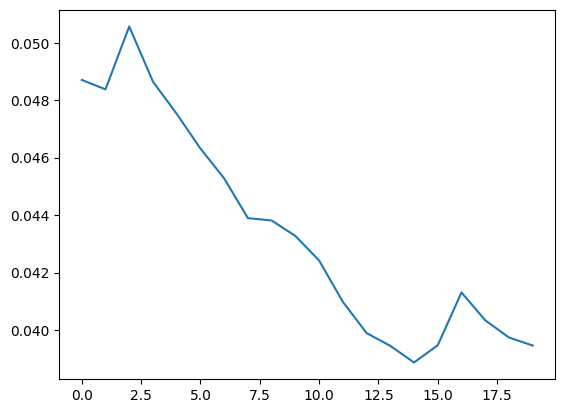

In [20]:
plt.plot(predictions_array[:, 2])

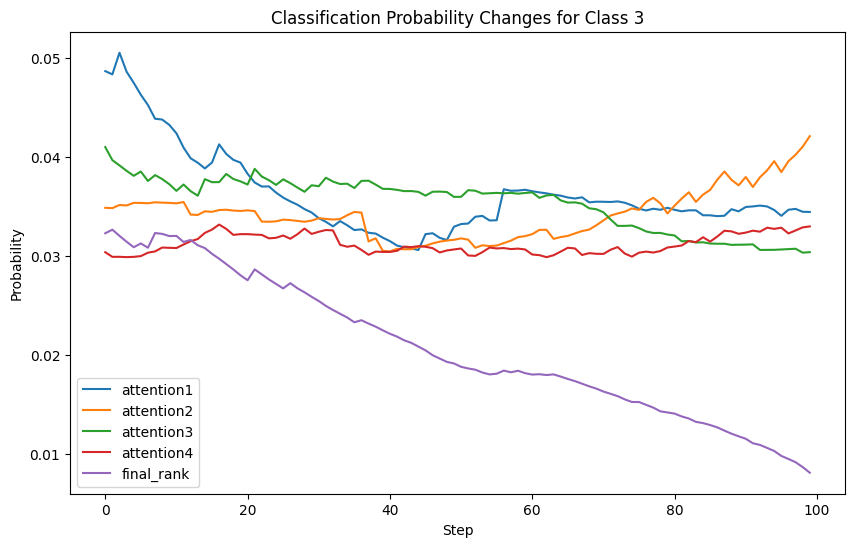

In [23]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

file_path = r'D:\Juntao\Data\ANDI3-T1\orig_nu\082_S_6690.nii'  
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()
mask_data = mask_evenly  

predictions_dict = {key: [] for key in ['attention1', 'attention2', 'attention3', 'attention4', 'final_rank']}

for key in predictions_dict.keys():
    df_sorted = df.sort_values(by=key, ascending=False)
    df_sorted = df_sorted.head(100)

    modified_image = image_data

    for index, row in df_sorted.iterrows():
        region_number = row['Region_ID']
        modified_image[mask_data == region_number] = 255 - modified_image[mask_data == region_number]

        input_tensor = torch.tensor(modified_image[np.newaxis, np.newaxis, ...], dtype=torch.float32).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predictions_dict[key].append(probabilities.cpu().detach().numpy())


plt.figure(figsize=(10, 6))

for key, predictions in predictions_dict.items():
    predictions_array = np.array(predictions).squeeze()
    plt.plot(predictions_array[:, 2], label=f'{key}')  

plt.xlabel('Step')
plt.ylabel('Probability')
plt.title('Classification Probability Changes for Class 3')
plt.legend()
plt.show()
